**TRANSFORMER (WORKING)**

In [1]:
# Equation Params
sigma = 10
rho = 28
beta = 8/3
initial_conditions = [-5.0, -10.0, 20.0] # initial conditions

# Time Params
t_end = 100                  # t final
t_points = 1000             # points
lyapunov_exponent = 1       # set to 1 to ignore lyapunov

# Split Param
split_ratio = 1/8

# Scaler Params (don't modify unless you know what you are doing)
feature_range = (0, 1)

# Model Hyperparams (don't need to modify unless want to)
learning_rate = 0.01
epochs = 400 # KEEP IT AT 400 FOR BEST PERF
batch_size = 1000

# Params for the iterative forecast 
num_iterations = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from keras.models import Model
from keras.layers import Dense, MultiHeadAttention, Input
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# define the Lorenz-63 system


def lorenz63(state, t, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# define Lorenz-63 parameters

sigma = 10
rho = 28
beta = 8/3

# define time span
t = np.linspace(0, t_end, t_points)

# compute Lyapunov time
lyapunov_time = 1 / np.abs(lyapunov_exponent)
t_lyapunov = t / lyapunov_time

# solve Lorenz-63 equations using odeint
solution = odeint(lorenz63, initial_conditions, t_lyapunov, args=(sigma, rho, beta))

# split solutions into separate variables
solution_x = solution[:, 0].reshape(-1, 1)
solution_y = solution[:, 1].reshape(-1, 1)
solution_z = solution[:, 2].reshape(-1, 1)

# split data into input and ground truth
points_length = int(len(solution) * split_ratio)

input_solution_x = solution_x[:points_length]
ground_truth_solution_x = solution_x[points_length:]


input_solution_y = solution_y[:points_length]
ground_truth_solution_y = solution_y[points_length:]

input_solution_z = solution_z[:points_length]
ground_truth_solution_z = solution_z[points_length:]

# scale for each variable
scaler_x = MinMaxScaler(feature_range=feature_range)
scaler_y = MinMaxScaler(feature_range=feature_range)
scaler_z = MinMaxScaler(feature_range=feature_range)

X_train_normalized_x = scaler_x.fit_transform(input_solution_x)
y_train_normalized_x = scaler_x.transform(ground_truth_solution_x)
X_train_normalized_x = np.reshape(X_train_normalized_x, (-1, 1, 1))
y_train_normalized_x = np.reshape(y_train_normalized_x, (-1, 1, 1))

X_train_normalized_y = scaler_y.fit_transform(input_solution_y)
y_train_normalized_y = scaler_y.transform(ground_truth_solution_y)
X_train_normalized_y = np.reshape(X_train_normalized_y, (-1, 1, 1))
y_train_normalized_y = np.reshape(y_train_normalized_y, (-1, 1, 1))

X_train_normalized_z = scaler_z.fit_transform(input_solution_z)
y_train_normalized_z = scaler_z.transform(ground_truth_solution_z)
X_train_normalized_z = np.reshape(X_train_normalized_z, (-1, 1, 1))
y_train_normalized_z = np.reshape(y_train_normalized_z, (-1, 1, 1))

# --------------------------------------------------------------------------------------------------------------------
def transformer_model(input_shape, num_layers=8, d_model=12, num_heads=1, dff=12, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    
    # Positional encoding
    input_length = input_shape[0]  # Assuming input_shape is (sequence_length, features)
    pos_encoding = np.arange(input_length)[:, np.newaxis] / np.power(100000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
    x += pos_encoding
    
    # Transformer Encoder layers 
    for _ in range(num_layers):
        # Multi-head self-attention
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
        # attn_output = Dropout(dropout_rate)(attn_output)
        # out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Position-wise feedforward network
        ffnn = Dense(dff, activation='relu') #(out1)
        # ffnn = Dense(d_model)(ffnn)
        # ffnn = Dropout(dropout_rate)(ffnn)
        # out2 = LayerNormalization(epsilon=1e-6)(out1 + ffnn)
        # x = out2
    
    # Output layer
    outputs = Dense(1, activation='linear')(x)  # Linear activation for single value output
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and compile the model
model_x = transformer_model(input_shape=(X_train_normalized_x.shape[1], 1))
model_y = transformer_model(input_shape=(X_train_normalized_y.shape[1], 1))
model_z = transformer_model(input_shape=(X_train_normalized_z.shape[1], 1))

# --------------------------------------------------------------------------------------------------------------------

# compile the models
optimizer_x, optimizer_y, optimizer_z = Adam(learning_rate=learning_rate), Adam(learning_rate=learning_rate), Adam(learning_rate=learning_rate)
model_x.compile(optimizer=optimizer_x, loss='mse')
model_y.compile(optimizer=optimizer_y, loss='mse')
model_z.compile(optimizer=optimizer_z, loss='mse')

# train the models
model_x.fit(X_train_normalized_x, X_train_normalized_x, epochs=epochs, batch_size=batch_size, verbose=1)
model_y.fit(X_train_normalized_y, X_train_normalized_y, epochs=epochs, batch_size=batch_size, verbose=1)
model_z.fit(X_train_normalized_z, X_train_normalized_z, epochs=epochs, batch_size=batch_size, verbose=1)

# predict using the trained models
predicted_solution_normalized_x = model_x.predict(y_train_normalized_x)
predicted_solution_normalized_y = model_y.predict(y_train_normalized_y)
predicted_solution_normalized_z = model_z.predict(y_train_normalized_z)

# back to original scale
predicted_solution_normalized_x_2d = predicted_solution_normalized_x.reshape(-1, 1)
predicted_solution_x = scaler_x.inverse_transform(predicted_solution_normalized_x_2d).flatten()

predicted_solution_normalized_y_2d = predicted_solution_normalized_y.reshape(-1, 1)
predicted_solution_y = scaler_y.inverse_transform(predicted_solution_normalized_y_2d).flatten()

predicted_solution_normalized_z_2d = predicted_solution_normalized_z.reshape(-1, 1)
predicted_solution_z = scaler_z.inverse_transform(predicted_solution_normalized_z_2d).flatten()

# error = np.mean(np.abs(ground_truth_solution_x - predicted_solution_x))
# print("Error:", error)

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step - loss: 14.2847
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 13.3818
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 12.5092
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 11.6674
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 10.8569
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 10.0780
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 9.3311
Epoch 8/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.6164
Epoch 9/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 7.9340
Epoch 10/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 7.2841
Epoch 11/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.6667
Epoch 12/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.0816
Epoch 13/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5.5288
Epoch 14/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.0080
Epoch 15/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4.5188
Epoch 16/400

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0517e-04
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0300e-04
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0012e-04
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.6775e-05
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.3208e-05
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.9659e-05
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.6326e-05
Epoch 8/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.3357e-05
Epoch 9/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.0843e-05
Epoch 10/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.8823e-05
Epoch 11/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.7284e-05
Epoch 12/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 7.6174e-05
Epoch 13/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.5414e-05
Epoch 14/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 7.4910e-05
Epoch 15/400
1/1 ━━━━━━━━━━━━

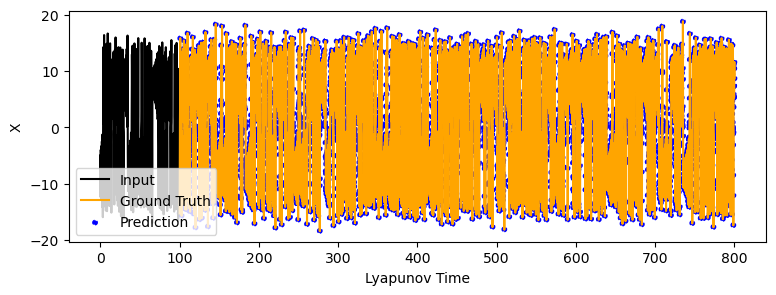

In [4]:
def iterative_forecast(model, initial_input, scaler, num_iterations, split_num, epochs):
    all_predictions = initial_input.copy()  # Make a copy of initial input
    for i in range(num_iterations):
        # define time span
        split_num = int(1/split_num)
        t = np.linspace(0, t_end*split_num**(i+1), t_points*split_num**(i+1))
        t = t / lyapunov_time

        # lorenz solved
        solution = odeint(lorenz63, initial_conditions, t, args=(sigma, rho, beta))
        solution = solution[:, 0].reshape(-1, 1)
        points_length = len(solution) // split_num
        input_solution = all_predictions
        ground_truth_solution = solution[points_length:]

        # normalize input data
        input_data_scaled = scaler.fit_transform(input_solution.reshape(-1, 1))
        ground_truth_solution_scaled = scaler.transform(ground_truth_solution.reshape(-1, 1))
        input_data_scaled = np.reshape(input_data_scaled, (-1, 1, 1))
        ground_truth_solution_scaled = np.reshape(ground_truth_solution_scaled, (-1, 1, 1))
    
        # train
        model.fit(input_data_scaled, input_data_scaled, epochs=epochs, batch_size=t_points, verbose=1)

        # predict
        predicted_solution_normalized = model.predict(ground_truth_solution_scaled)

        # back to original
        predicted_solution_normalized_2d = predicted_solution_normalized.reshape(-1, 1)
        predicted_solution = scaler.inverse_transform(predicted_solution_normalized_2d).flatten()

        # append
        all_predictions = np.concatenate((all_predictions, predicted_solution.reshape(-1, 1)))

        plt.figure(figsize=(9, 3))
        plt.plot(t[:points_length], input_solution, label='Input', color='black')
        plt.plot(t[points_length:], ground_truth_solution, label='Ground Truth', color='orange')
        plt.scatter(t[points_length:], predicted_solution, label='Prediction', color='blue', linestyle='--', s=10)
        plt.xlabel('Lyapunov Time')
        plt.ylabel('X')
        plt.legend()

# perform recursive prediction for x variable
all_predictions_x = iterative_forecast(model_x, np.concatenate((input_solution_x, predicted_solution_x.reshape(-1, 1))), scaler_x, num_iterations, split_ratio, epochs)

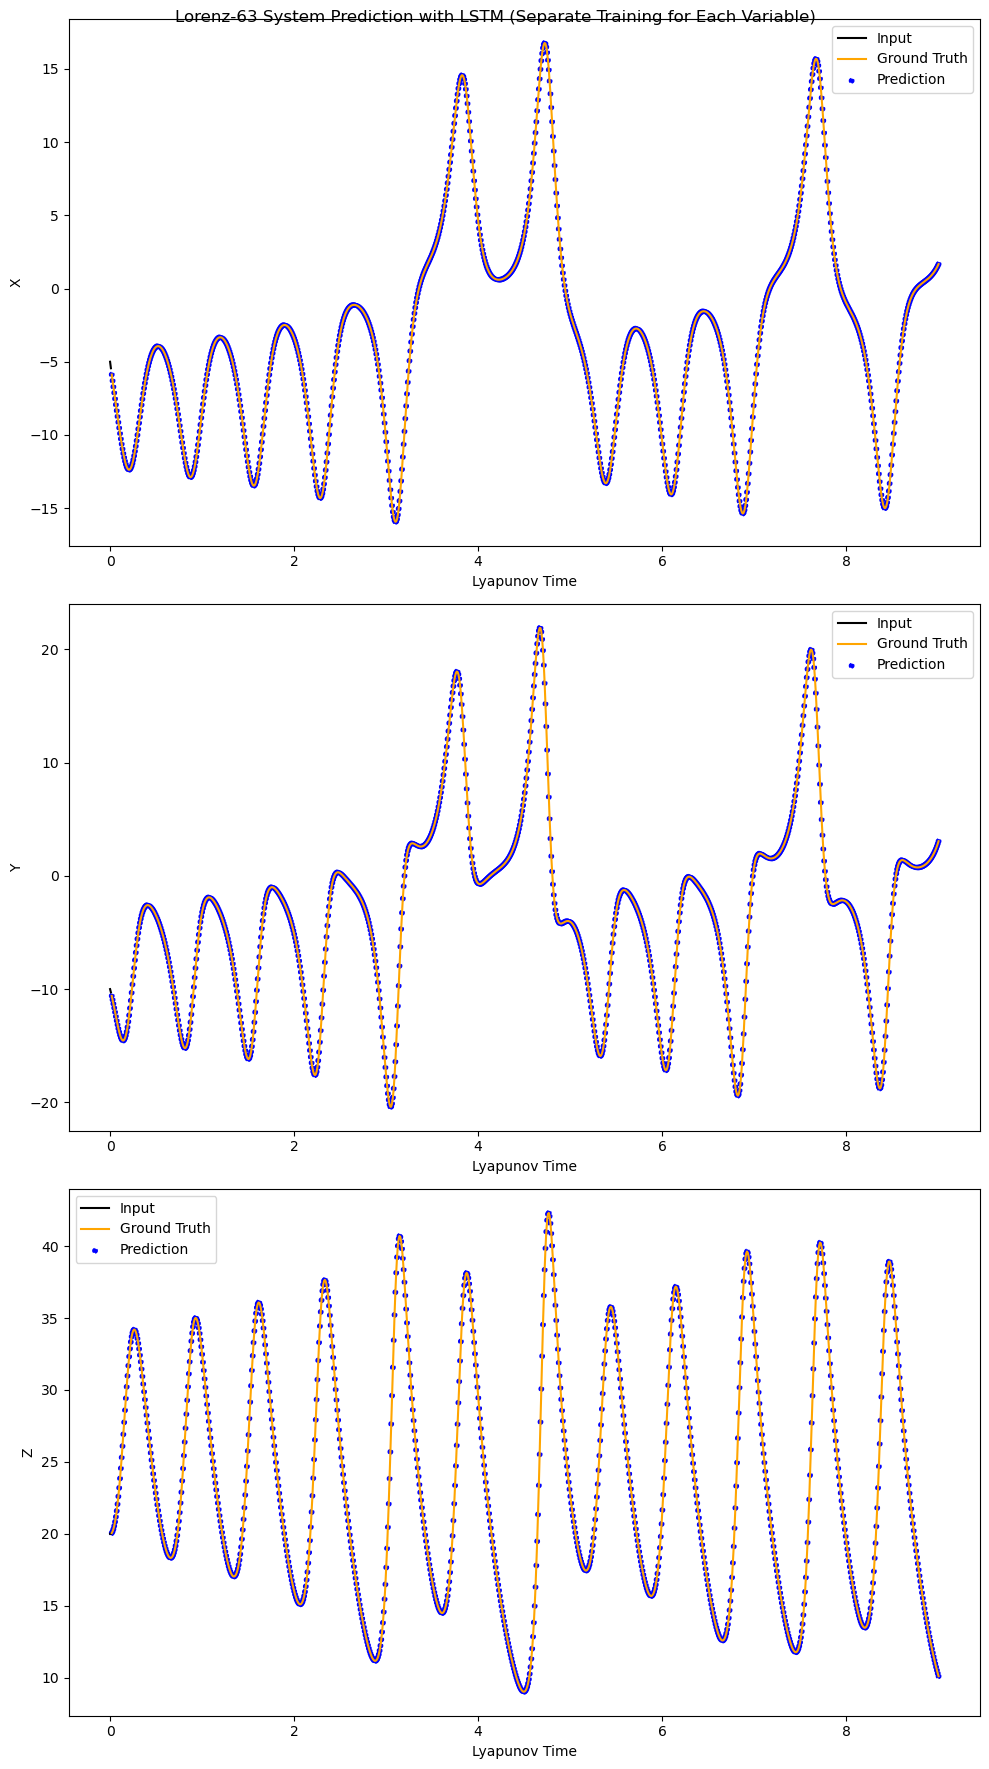

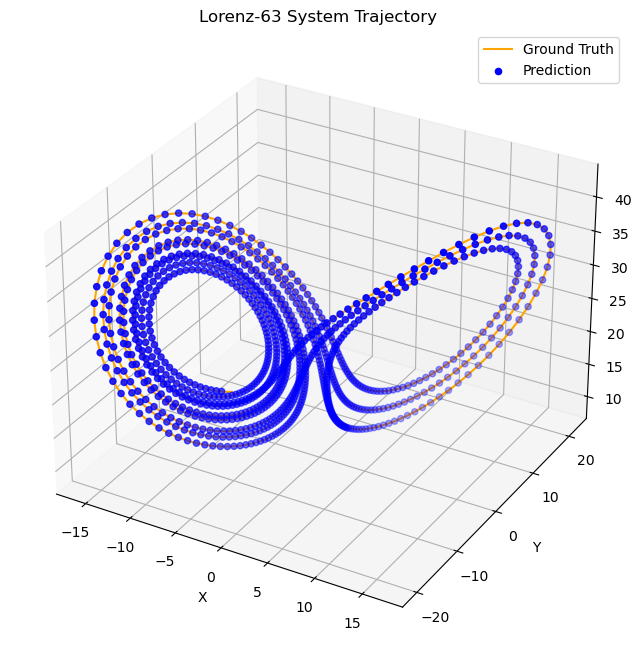

In [16]:
# plot
plt.figure(figsize=(10, 18))

plt.subplot(3, 1, 1)
plt.plot(t_lyapunov[:points_length], input_solution_x, label='Input', color='black')
plt.plot(t_lyapunov[points_length:], ground_truth_solution_x, label='Ground Truth', color='orange')
plt.scatter(t_lyapunov[points_length:], predicted_solution_x, label='Prediction', color='blue', linestyle='--', s=10)
plt.xlabel('Lyapunov Time')
plt.ylabel('X')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_lyapunov[:points_length], input_solution_y, label='Input', color='black')
plt.plot(t_lyapunov[points_length:], ground_truth_solution_y, label='Ground Truth', color='orange')
plt.scatter(t_lyapunov[points_length:], predicted_solution_y, label='Prediction', color='blue', linestyle='--', s=10)
plt.xlabel('Lyapunov Time')
plt.ylabel('Y')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_lyapunov[:points_length], input_solution_z, label='Input', color='black')
plt.plot(t_lyapunov[points_length:], ground_truth_solution_z, label='Ground Truth', color='orange')
plt.scatter(t_lyapunov[points_length:], predicted_solution_z, label='Prediction', color='blue', linestyle='--', s=10)
plt.xlabel('Lyapunov Time')
plt.ylabel('Z')
plt.legend()

plt.suptitle('Lorenz-63 System Prediction with LSTM (Separate Training for Each Variable)')
plt.tight_layout()

# 3d model
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# ground truth trajectory
ax.plot(solution_x.flatten(), solution_y.flatten(), solution_z.flatten(), label='Ground Truth', color='orange')

# prediction
ax.scatter(predicted_solution_x, predicted_solution_y, predicted_solution_z, label='Prediction', color='blue')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz-63 System Trajectory')

plt.legend()
plt.show()
